<a href="https://colab.research.google.com/github/meln-ds/Basic-A-B-Testing/blob/master/Basic_AB_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind


url = 'https://raw.githubusercontent.com/meln-ds/Basic-A-B-Testing/master/marketing_new.csv'
marketing = pd.read_csv(url)

# Inspect the columns available
marketing.head()

,Unnamed: 0,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,DoW,channel_code,is_correct_lang
0,0,a100000029,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,NaN,House Ads,True,0.0,1.0,Yes
1,1,a100000030,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,NaN,House Ads,True,0.0,1.0,Yes
2,2,a100000031,2018-01-01,House Ads,personalization,True,English,English,24-30 years,2018-01-01,NaN,House Ads,True,0.0,1.0,Yes
3,3,a100000032,2018-01-01,House Ads,personalization,True,English,English,30-36 years,2018-01-01,NaN,House Ads,True,0.0,1.0,Yes
4,4,a100000033,2018-01-01,House Ads,personalization,True,English,English,36-45 years,2018-01-01,NaN,House Ads,True,0.0,1.0,Yes


#### **1. Test allocation**


In [2]:
# For this A/B testing, users whose marketing channel is email were segregated into two groups: control and treatment group.
# Treatment group received a personalized email. The classification is stored in the variant column

email_df = marketing[marketing['marketing_channel'] == 'Email']
user_alloc = email_df.groupby('variant')['user_id'].nunique()
user_alloc

variant
control            270
personalization    284
Name: user_id, dtype: int64

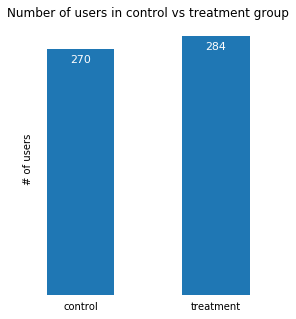

In [3]:
# Visualize the user allocation. I cleaned up the viz a bit, remove the frame and move the data labels into within the bars themselves
plt.figure(figsize=(4,5))
bars = plt.bar(['control','treatment'],user_alloc, width=0.5)
plt.title('Number of users in control vs treatment group')
plt.ylabel('# of users')
plt.box(False)
plt.tick_params(left=False, bottom=False, labelleft=False)
plt.xticks(rotation=0)
for bar in bars: # direct label each bar with Y axis values
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 15, str(int(bar.get_height())), 
                 ha='center', color='w', fontsize=11)

plt.show()


> As we can observe there isn't a big difference between the two groups. However, in real life, experimenters will need to bear in mind that having the same numbers of users in these groups may not guarantee a meaningful results. Randomness for instance is very important in allocating your users and without it your groups might be very skewed and not an accurate representation.

#### **2. Lift and Statistical Significance**

> Lift is the first question to ask in A/B testing. It is the % difference between your control page and a successful test variant. In this context, the question is - Is my conversion rate under the treatment group higher than the control group, and by how much?

> 








In [4]:
# Extract conversion results of control and treatment groups

subscriber_df = email_df.groupby(['user_id','variant'])['converted'].max().unstack(level=1)
control = subscriber_df['control'].dropna()
treatment = subscriber_df['personalization'].dropna()

# Calculate lift
control_conv = np.mean(control)
treatment_conv = np.mean(treatment)
lift = (treatment_conv - control_conv)/control_conv

print('Control conversion rate: '+'{:.2%}'.format(control_conv)) 
print('Treatment conversion rate: '+'{:.2%}'.format(treatment_conv)) 
print('Lift: '+'{:.2%}'.format(lift)) 

Control conversion rate: 28.15%
Treatment conversion rate: 39.08%
Lift: 38.85%


> 38.85% seems to be a pretty good result, but how certain are we that the result obtained under our treatment group did not just happen by chance? Statistical significance is a validator of our calculated lift. To measure this, we employ the scipy stats's independent t-test, with significance level = 5%. I'm not going into details of what t-test is exactly, but there are plenty of resources online that you can look into (Khan Academy AP Stats is a good start). 



In [5]:
ttest = ttest_ind(control,treatment)
print(ttest)

Ttest_indResult(statistic=-2.7343299447505074, pvalue=0.006451487844694175)


> Our p-value is less than our significance level of 5%, which means we can reject the null hypothesis, and that our result is statistically significant.



#### 3. A/B testing and segmentation

> Overall, the A/B testing result indicates that personalized emails lead to a higher conversion rate compared to a normal email. However, is this the case for all customer segments ? Bear in mind that different customer segments may react differently to a product functionality or marketing tactics.

> In this section, we will break down the A/B testing result further to different customer segments. It would not be ideal to rewrite all the code from scratch for each segment, so we will define a function that can be reuseable, knowing that our dataset format will remain the same.

In [0]:
# Build a function for calculating lift

def AB_lift(control,treatment):
  control_conv = np.mean(control)
  treatment_conv = np.mean(treatment)
  return (treatment_conv - control_conv)/control_conv
  
# Build a function for calculating p-value

def AB_ttest(control,treatment):
  return ttest_ind(control,treatment)[1]

# Build a function to go through each customer subsegment from a segment column specified by the user

def AB_test(segment):
  # Build a for loop for each subsegment
  for subsegment in np.unique(marketing[segment].values):
    print(subsegment)

    # Filter users reached via email and belonging to relevant subsegment
    marketing_filtered = marketing[(marketing['marketing_channel'] == 'Email') & (marketing[segment] == subsegment)]

    # Repeat the same steps in section 2
    subscriber_df = marketing_filtered.groupby(['user_id','variant'])['converted'].max().unstack(level=1)
    control = subscriber_df['control'].dropna()
    treatment = subscriber_df['personalization'].dropna()

    # Return lift and p-value as a tuple
    print('Lift: '+ str(AB_lift(control,treatment)) + ', '+'p-value: '+ str(AB_ttest(control,treatment)))



  



In [17]:
# Run our function on language displayed

AB_test('language_displayed')

Arabic
Lift: 0.4999999999999999, p-value: 0.5795840000000001
English
Lift: 0.3900293255131965, p-value: 0.026991701290720815
German
Lift: -0.016203703703703685, p-value: 0.8494394170062678
Spanish
Lift: 1.6666666666666667, p-value: 0.040156718110477524


In [0]:
# It looks like our personalized emails worked very well for Spanish audience, but not so much for German audience.

In [19]:
# And another one on age group

AB_test('age_group')

0-18 years
Lift: 1.2140000000000002, p-value: 0.0038724494391297226
19-24 years
Lift: 1.0624151967435547, p-value: 0.0030623836114689134
24-30 years
Lift: 1.611851851851852, p-value: 0.00018743381094867337
30-36 years
Lift: -1.0, p-value: 0.0023238487431765137
36-45 years
Lift: -0.8522727272727273, p-value: 0.01797568600978829
45-55 years
Lift: -0.7222222222222223, p-value: 0.043062339688201196
55+ years
Lift: -1.0, p-value: 0.0016358623456360435


In [0]:
# Results suggest our younger audience responded more positively to the personlized emails, whereas the older audience were less welcoming.
# Perhaps they thought it sounded like an invasion of privacy ?
# Either way, segmentation helps the marketing team drill down further and tweak their experiments accordingly.

**Potential extensions:**

The AB test analysis above is still fairly basic, and there is a lot of room for improvements. For example, one can improve the AB_test function to include a bar chart of the lift values for the segments. This should be relatively easy. There are also more AB tests that the team could run, for example, sending emails on a weekday vs a weekend. The result can be analyzed in a similar fashion.

